# DECam image querying

This is currently just a test to see if image querying + fits file displaying works

Primarily from the [NOIRLab API examples](https://github.com/NOAO/nat-nb/blob/master/sia.ipynb)

In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd

## Downloading images from the Legacy Survey

Files are accessed through the DR10 Web Access directories mentioned on the [Legacy Survey Website](https://www.legacysurvey.org/dr10/files/).


TO DO:
- error checking if the image at the given section and brick don't exist
- figure out a method to find out which brick corresponds to a given RA/DEC

In [2]:
def obtain_image(brick, filter, reset_cache=True):
    """Returns the header and data for a coadded FITS file queried from the Legacy Survey DR10 portal
    
    Files are accessed with a url pattern of `<section>/<brick>/legacysurvey-<brick>-image-<filter>.fits.fz`
    as documented on the [Legacy Survey website](https://www.legacysurvey.org/dr10/files/#image-stacks-south-coadd).
    Images can be deleted from cache after the header and data are extracted.
    
    Parameters
    ----------
    brick:  `str`
        Brick name of image: RRRr(p/m)DDd
    filter: `str`
        Photographic filter of image to request (g, r, i, z)
    reset_cache: `bool`, default `True`
        Clears the downloaded image from the cache
        
    Returns
    -------
    header: `CompImageHeader`
        Astropy object of the FITS header data
    data: `ndarray`
        Numpy NDarray of FITS image data
    """
    
    url = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/coadd/"
    image_string = url + f"{brick[0:3]}/{brick}/legacysurvey-{brick}-image-{filter}.fits.fz"
    
    print(f"Downloading {image_string}....")

    # assumes only one image, in the first non-primary header file
    with fits.open(image_string) as hdu:
        header = hdu[1].header
        data = hdu[1].data
    
    if reset_cache:
        print("Clearing download cache...")
        data_utils.clear_download_cache(image_string)
    
    return header, data

header, data = obtain_image("0001m002", "g", reset_cache=False)

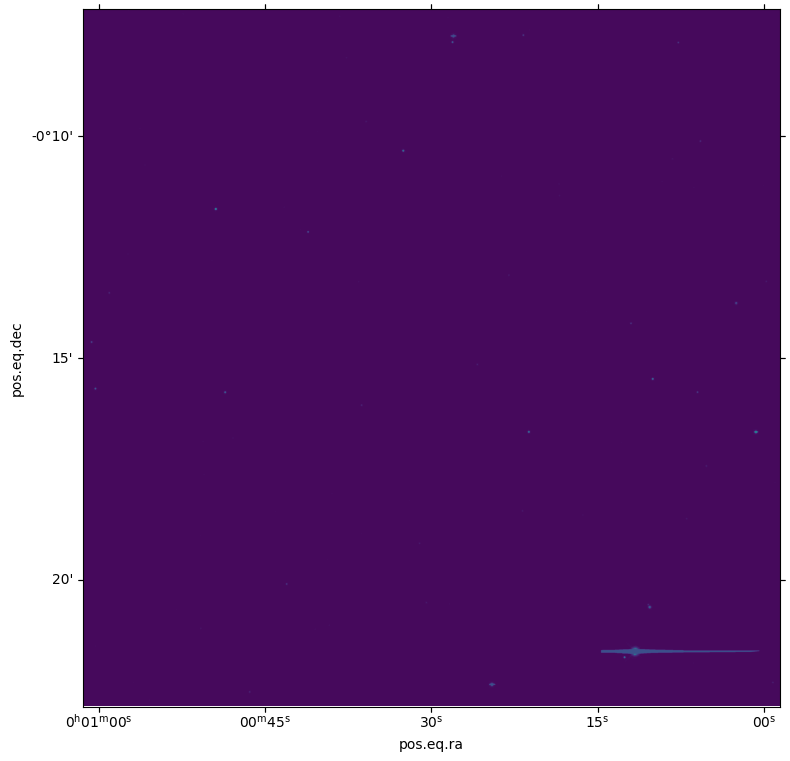

In [3]:
def plot_image(header, data):
    """Plots the image based on header and image data"""
    
    wcs = WCS(header)

    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection=wcs)
    lon = ax.coords['ra']
    lat = ax.coords['dec']
    ax.imshow(data, norm='linear')

    plt.tight_layout()
    
plot_image(header, data)

## Querying the NOIRLab Astro Data Lab

to get the images we need:
- query the data lab for brick names in some RA/DEC region (ls_dr10.bricks)
- iterate through the list of brick names
- for each brick name:
  - download the image associated with it
  - extract header and image data
  - send to source extraction etc...

In [4]:
# this function isn't actually necessary for the program but was a test to see how brick names worked
def brick_identifier(ra, dec):
    """Creates a string corresponding to the brick name of the image at a given RA/DEC
    in the format `RRRr(p/m)DDd`
    
    Example: (0.125, -0.25) -> 0001m002
    
    Parameters
    ----------
    ra: `float`
        Right ascension (degrees)
    dec: `float`
        Declination (degrees)
        
    Returns
    -------
    brickname: `str`
        Name of "brick" image
    """
    # ra RRR.rrr -> RRRr
    # dec (+/-)DD.ddd -> (p/m)DDd
    
    # whether declination is positive or negative
    sign = "p"
    if dec < 0:
        sign = "m"
    
    # remove decimal and sign
    mod_ra = round(ra*10)
    mod_dec = abs(round(dec*10))
    
    brickname = f"{mod_ra:04}{sign}{mod_dec:03}"
    print(f"Brick name for RA={ra} and DEC={dec}: {brickname}")
    
    return brickname
    
brickname = brick_identifier(0.125, -0.25)

Brick name for RA=0.125 and DEC=-0.25: 0001m002


In [12]:
print(qc.schema("ls_dr10.bricks_s"))


Schema: ls_dr10
 Table: bricks_s

     Column Name   Description
     -----------   -----------
           ext_r   Extinction in r-band
           ext_i   Extinction in i-band
       brickname   Name of the brick
              ra   RA of the center of the brick
             dec   DEC of the center of the brick
          nexp_g   Median number of exposures in the unique area (i.e. BRICK_
                   PRIMARY area) of the brick in g-band
          nexp_r   Median number of exposures in the unique area (i.e. BRICK_
                   PRIMARY area) of the brick in r-band
          nexp_i   Median number of exposures in the unique area (i.e. BRICK_
                   PRIMARY area) of the brick in i-band
          nexp_z   Median number of exposures in the unique area (i.e. BRICK_
                   PRIMARY area) of the brick in z-band
    nexphist_g_1   Histogram of number of pixels in the unique brick area wit
                   h 0 exposures in g
    nexphist_g_2   Histogram of num

In [84]:
def query_bricks(ra, dec, dist):
    """Queries the Astro Data Lab for brick names and associated RA/DEC based on the given RA/DEC
    
    dist is in degrees
    """
    
    # one RA/DEC pair, then some set range around that?
    ra_max = ra + dist
    ra_min = ra - dist
    dec_max = dec + dist
    dec_min = dec - dist

    query = f"""
    SELECT brickname, ra, ra1, ra2, dec, dec1, dec2
    FROM ls_dr10.bricks_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    LIMIT 10
    """

    print(query)
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    
    return brick_info

brick_df = query_bricks(100, -25, 1.0)

In [ ]:
# get all the brick names and ra/dec of every brick below a declination of 30
# with at least 1 observation in the g filter
# this takes about 15 seconds to get ~337k brick names

query = f"""
        SELECT brickname, ra, ra1, ra2, dec, dec1, dec2
        FROM ls_dr10.bricks_s
        WHERE dec <= 30 AND nexp_g >= 1
        """

brick_df = qc.query(sql=query, fmt="pandas")
brick_df

,brickname,ra,ra1,ra2,dec,dec1,dec2
0,0900m897,90.000,72.000,108.000,-89.75,-89.875,-89.625
1,0112m895,11.250,0.000,22.500,-89.50,-89.625,-89.375
2,0337m895,33.750,22.500,45.000,-89.50,-89.625,-89.375
3,0562m895,56.250,45.000,67.500,-89.50,-89.625,-89.375
4,0787m895,78.750,67.500,90.000,-89.50,-89.625,-89.375
...,...,...,...,...,...,...,...
337218,3587p300,358.704,358.560,358.848,30.00,29.875,30.125
337219,3589p300,358.992,358.848,359.136,30.00,29.875,30.125
337220,3592p300,359.280,359.136,359.424,30.00,29.875,30.125
337221,3595p300,359.568,359.424,359.712,30.00,29.875,30.125


In [91]:
# get all the brick names and ra/dec of every brick below a declination of 30
# with NO observations in the g filter
# ~5s for 16k bricks

query = f"""
        SELECT brickname, ra, ra1, ra2, dec, dec1, dec2, nexp_g, nexp_i, nexp_r, nexp_z, wise_nobs_1, wise_nobs_2, wise_nobs_3, wise_nobs_4
        FROM ls_dr10.bricks_s
        WHERE dec <= 30 AND nexp_g < 1
        """

non_g_bricks = qc.query(sql=query, fmt="pandas")
non_g_bricks

,brickname,ra,ra1,ra2,dec,dec1,dec2,nexp_g,nexp_i,nexp_r,nexp_z,wise_nobs_1,wise_nobs_2,wise_nobs_3,wise_nobs_4
0,0180m897,18.000,0.000,36.000,-89.75,-89.875,-89.625,0,0,0,0,483,485,23,23
1,0540m897,54.000,36.000,72.000,-89.75,-89.875,-89.625,0,0,0,0,490,492,22,23
2,1260m897,126.000,108.000,144.000,-89.75,-89.875,-89.625,0,0,0,0,486,495,25,25
3,1620m897,162.000,144.000,180.000,-89.75,-89.875,-89.625,0,0,0,0,455,469,23,23
4,1980m897,198.000,180.000,216.000,-89.75,-89.875,-89.625,0,0,0,0,459,471,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15884,3293p300,329.328,329.184,329.472,30.00,29.875,30.125,0,0,0,2,253,254,10,10
15885,3296p300,329.616,329.472,329.760,30.00,29.875,30.125,0,0,0,2,255,256,11,11
15886,3299p300,329.904,329.760,330.048,30.00,29.875,30.125,0,0,0,2,253,254,13,12
15887,3301p300,330.192,330.048,330.336,30.00,29.875,30.125,0,0,0,2,251,252,15,14


Almost all of the DR10 bricks have at least one g-band observation associated with them, and those that don't are mostly along the edge of the Milky Way plane and the Magellanic Clouds. Out of the ~16k bricks that aren't accounted for in the g-band, only about 2900 only have WISE (W1, W2, W3, W4) observations that would require different calibration and image processing to handle.

In [115]:
# bricks with r band observations
r_bricks = non_g_bricks[non_g_bricks['nexp_r']!=0]
# no r band, but i band
i_bricks = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']!=0)]
# no r or i bands, but z band
z_bricks = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']==0) & (non_g_bricks['nexp_z']!=0)]
# no r, i, or z
wise_only = non_g_bricks[(non_g_bricks['nexp_r']==0) & (non_g_bricks['nexp_i']==0) & (non_g_bricks['nexp_z']==0)]
wise_only

,brickname,ra,ra1,ra2,dec,dec1,dec2,nexp_g,nexp_i,nexp_r,nexp_z,wise_nobs_1,wise_nobs_2,wise_nobs_3,wise_nobs_4
0,0180m897,18.000000,0.000000,36.000000,-89.75,-89.875,-89.625,0,0,0,0,483,485,23,23
1,0540m897,54.000000,36.000000,72.000000,-89.75,-89.875,-89.625,0,0,0,0,490,492,22,23
2,1260m897,126.000000,108.000000,144.000000,-89.75,-89.875,-89.625,0,0,0,0,486,495,25,25
3,1620m897,162.000000,144.000000,180.000000,-89.75,-89.875,-89.625,0,0,0,0,455,469,23,23
4,1980m897,198.000000,180.000000,216.000000,-89.75,-89.875,-89.625,0,0,0,0,459,471,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15854,0380p297,38.099042,37.955272,38.242812,29.75,29.625,29.875,0,0,0,0,217,209,24,13
15855,1019p297,101.932907,101.789137,102.076677,29.75,29.625,29.875,0,0,0,0,209,204,12,12
15874,2783p300,278.352000,278.208000,278.496000,30.00,29.875,30.125,0,0,0,0,316,318,22,22
15875,2786p300,278.640000,278.496000,278.784000,30.00,29.875,30.125,0,0,0,0,304,305,20,20


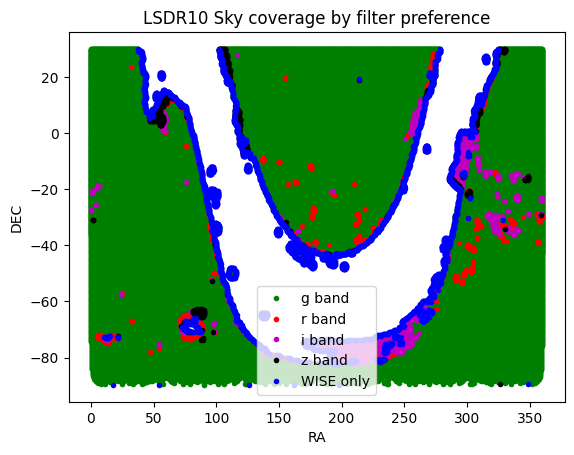

In [114]:
fig, ax = plt.subplots(1,1)
ax.plot(brick_df['ra'], brick_df['dec'], 'g.', label="g band")
# ax.plot(non_g_bricks['ra'], non_g_bricks['dec'], 'b.', label="non g band")
ax.plot(r_bricks['ra'], r_bricks['dec'], 'r.', label="r band")
ax.plot(i_bricks['ra'], i_bricks['dec'], 'm.', label="i band")
ax.plot(z_bricks['ra'], z_bricks['dec'], 'k.', label="z band")
ax.plot(wise_only['ra'], wise_only['dec'], 'b.', label="WISE only")


ax.set(title="LSDR10 Sky coverage by filter preference", xlabel="RA", ylabel="DEC")
ax.legend()
plt.show()

All bricks in the `brick_df` dataframe will have an associated g-band FITS image that can be downloaded from the DR10 website.

Clearing download cache...


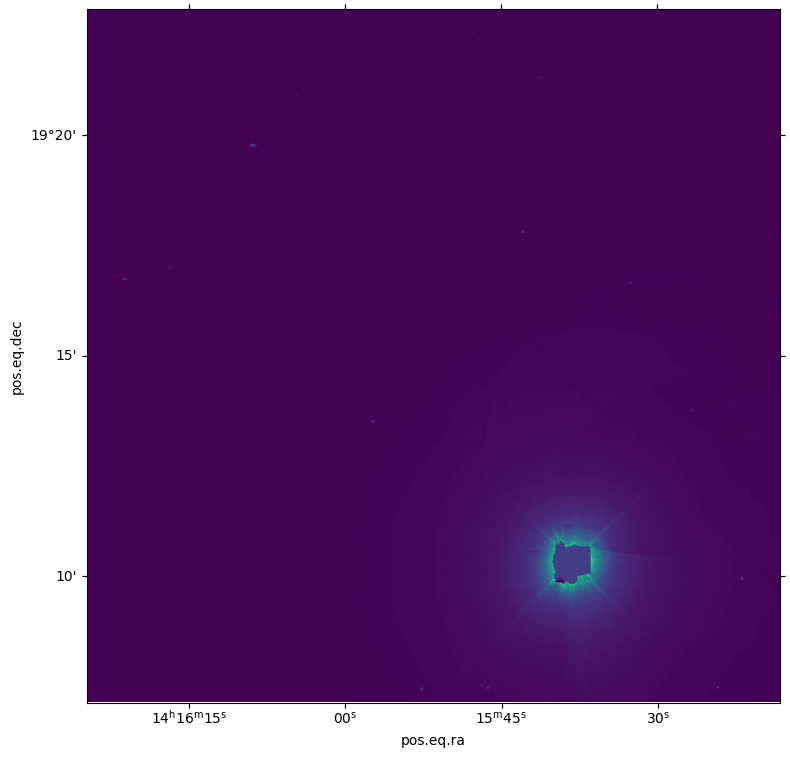

In [116]:
arcturus = "2139p192"
arc_head, arc_data = obtain_image(arcturus, "g", reset_cache=False)
plot_image(arc_head, arc_data)


In [60]:
def iterate_bricks(brick_df):
    """Iterate through a dataframe of brick names and generate the images from them
    """
    
    image_array = []
    
    for brick in brick_df['brickname']:
        print(brick)
        head, data = obtain_image(brick, "g")
        image_array.append((head, data))  
    
    return image_array
        
image_array = iterate_bricks(brick_df)

0900m897
Clearing download cache...
0112m895
Clearing download cache...
0337m895
Clearing download cache...
0562m895
Clearing download cache...
0787m895
Clearing download cache...
1012m895
Clearing download cache...
1237m895
Clearing download cache...
1462m895
Clearing download cache...
1687m895
Clearing download cache...
1912m895
Clearing download cache...


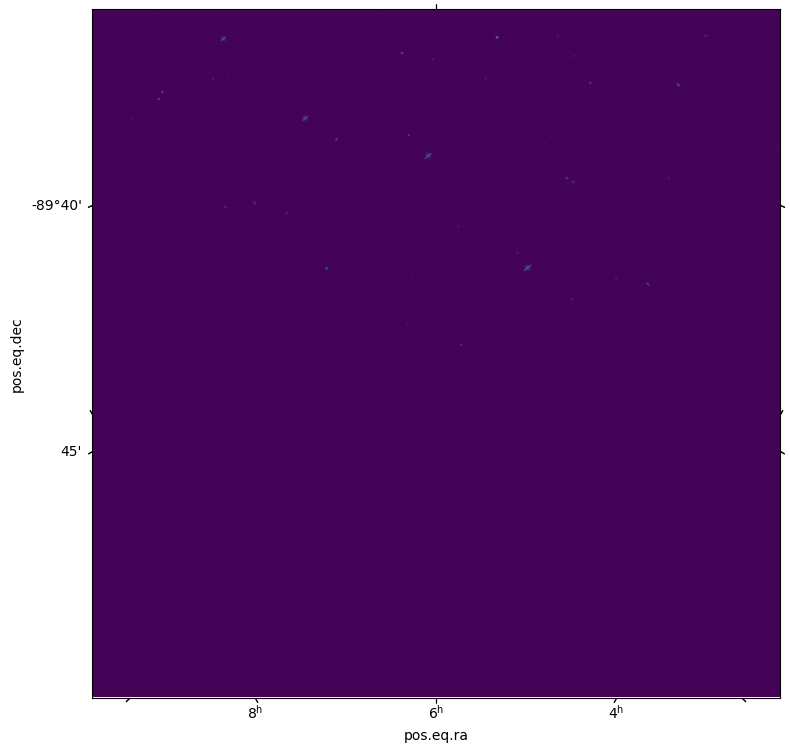

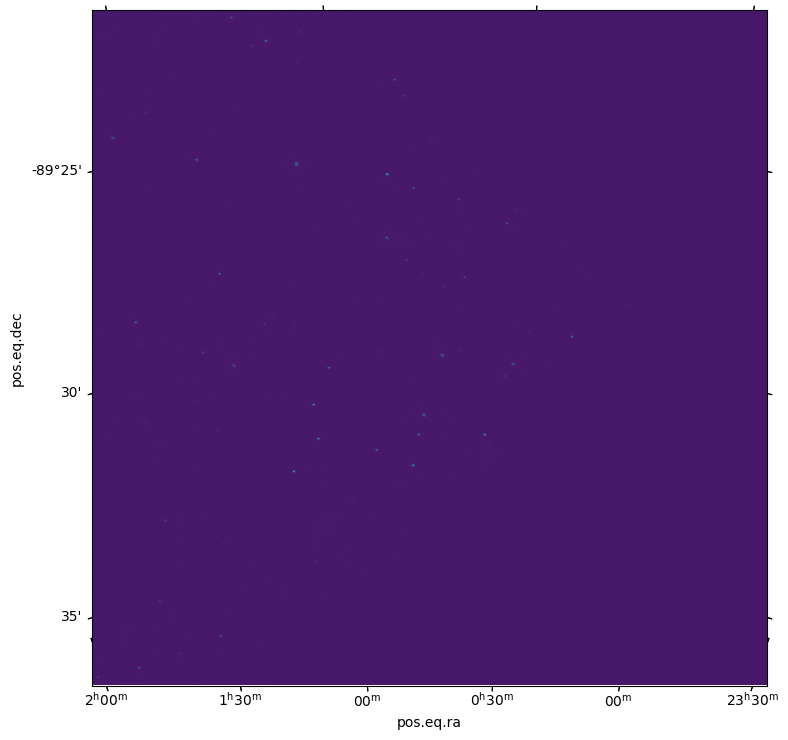

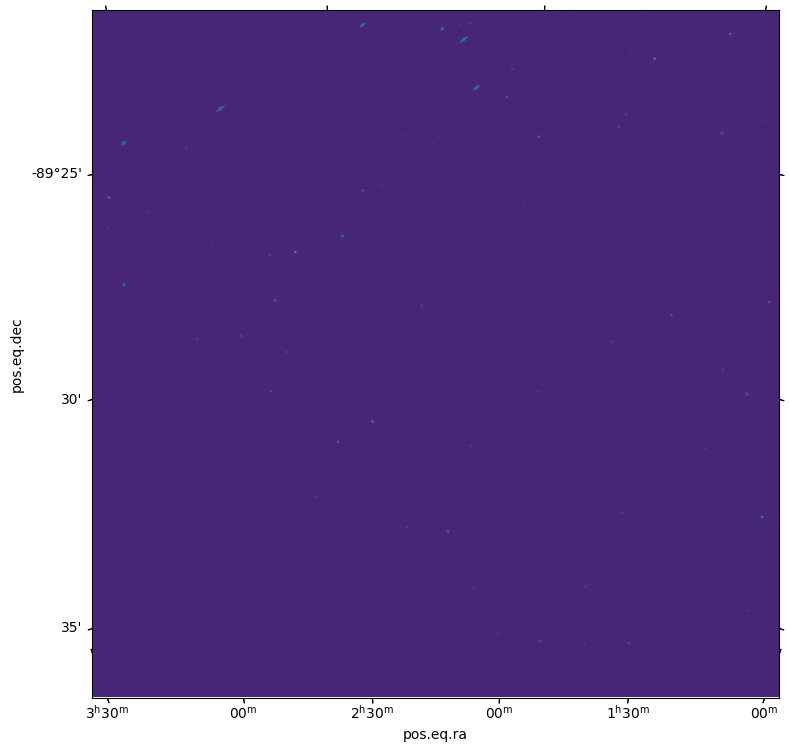

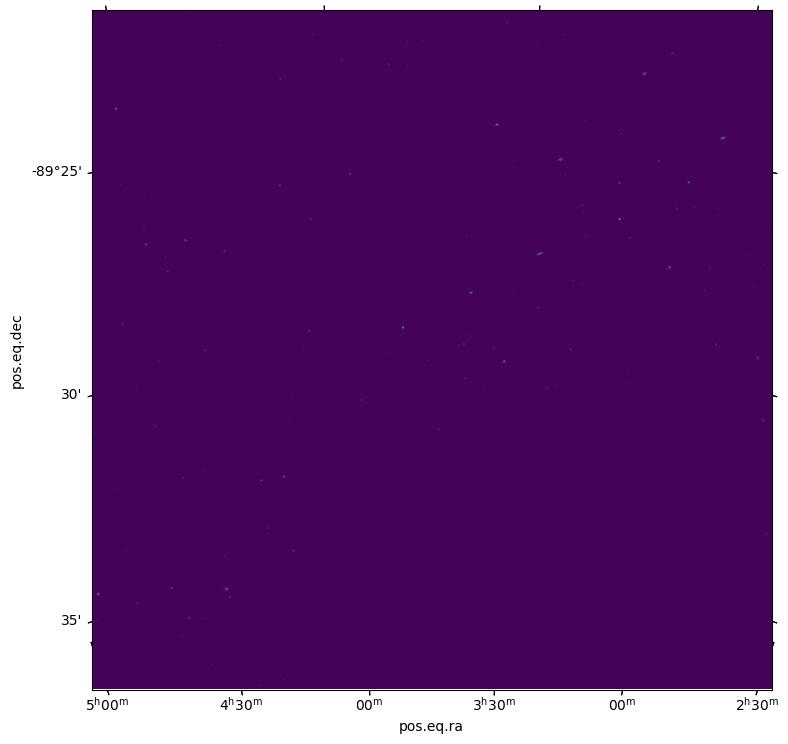

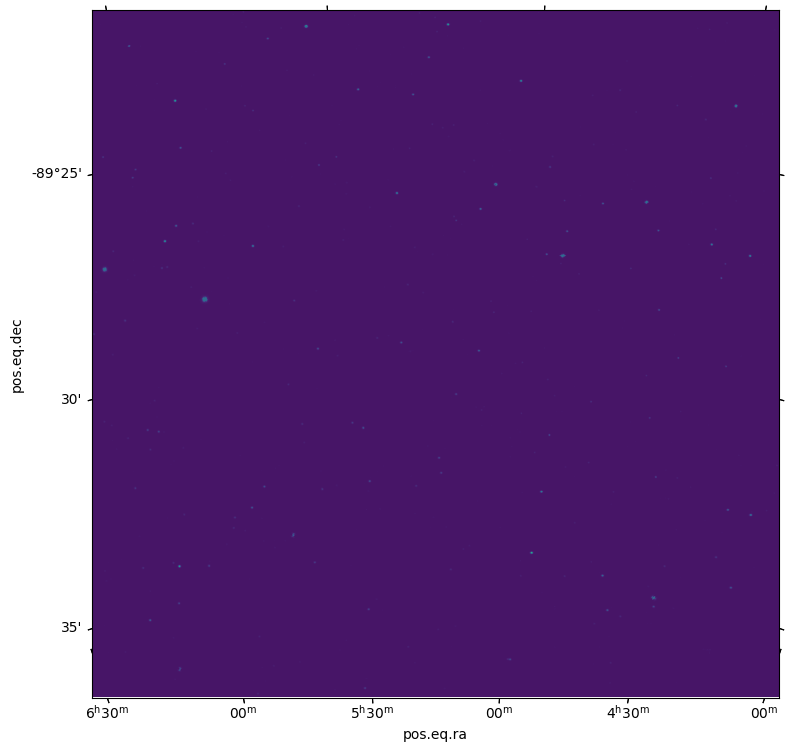

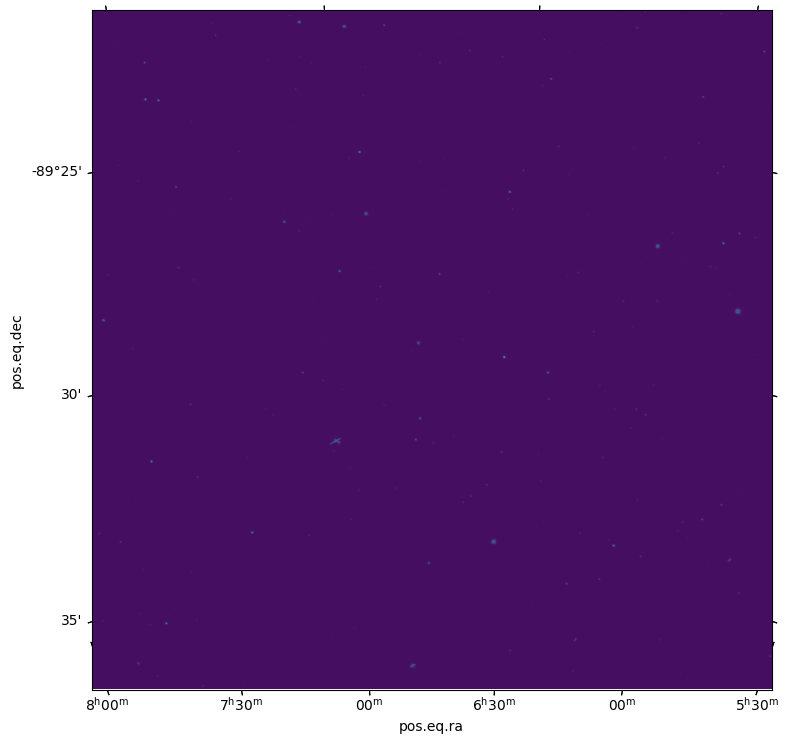

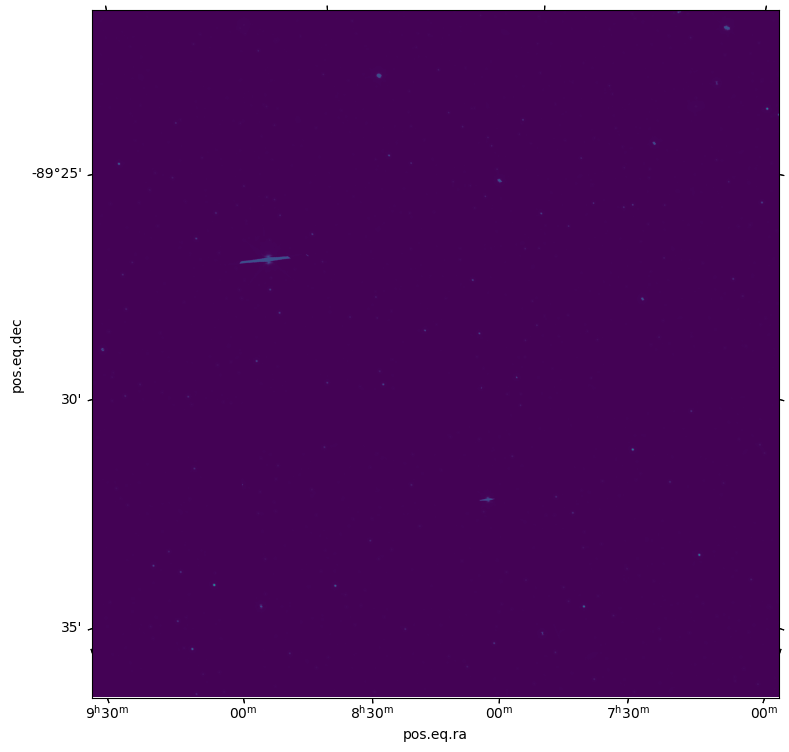

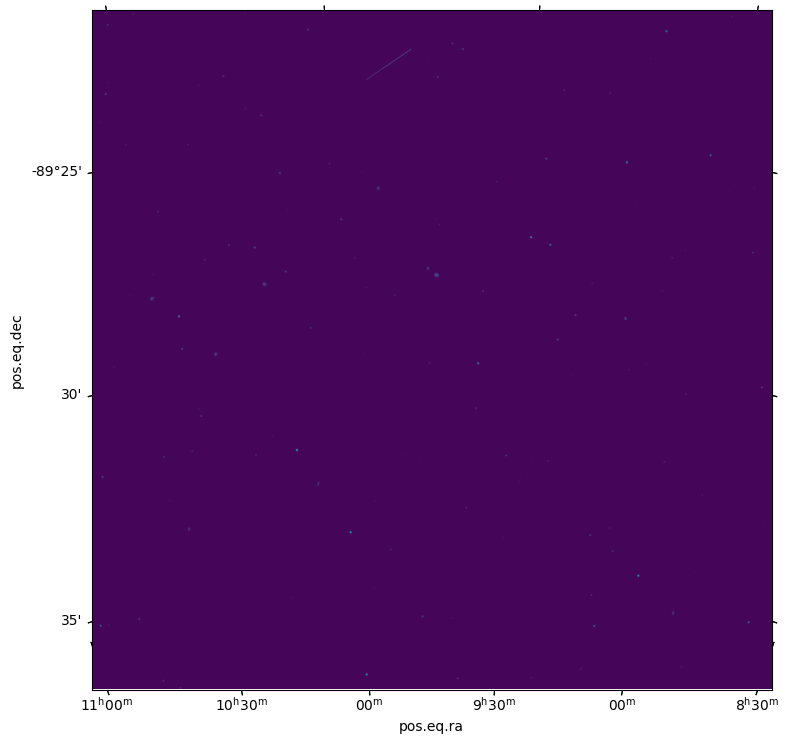

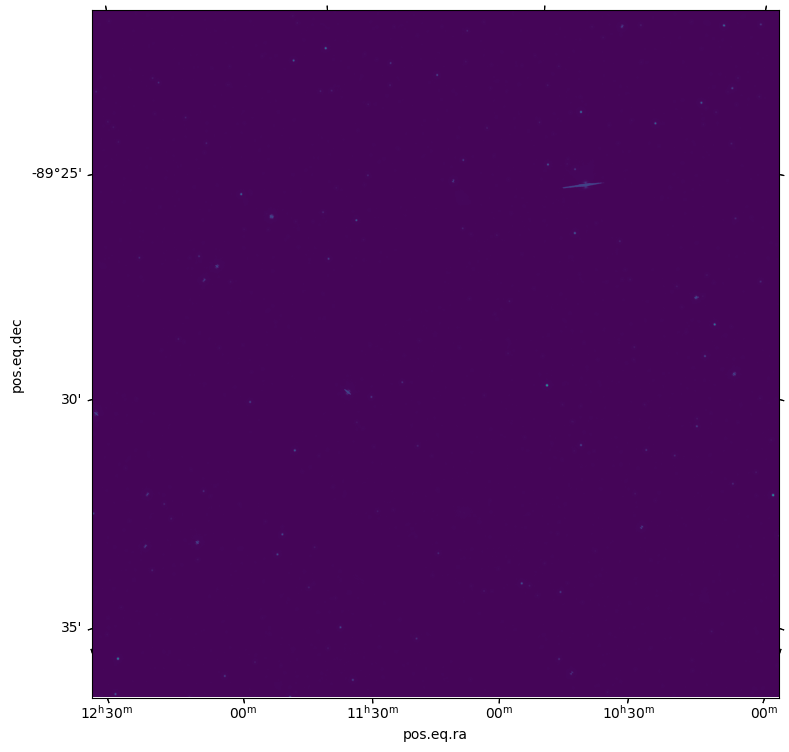

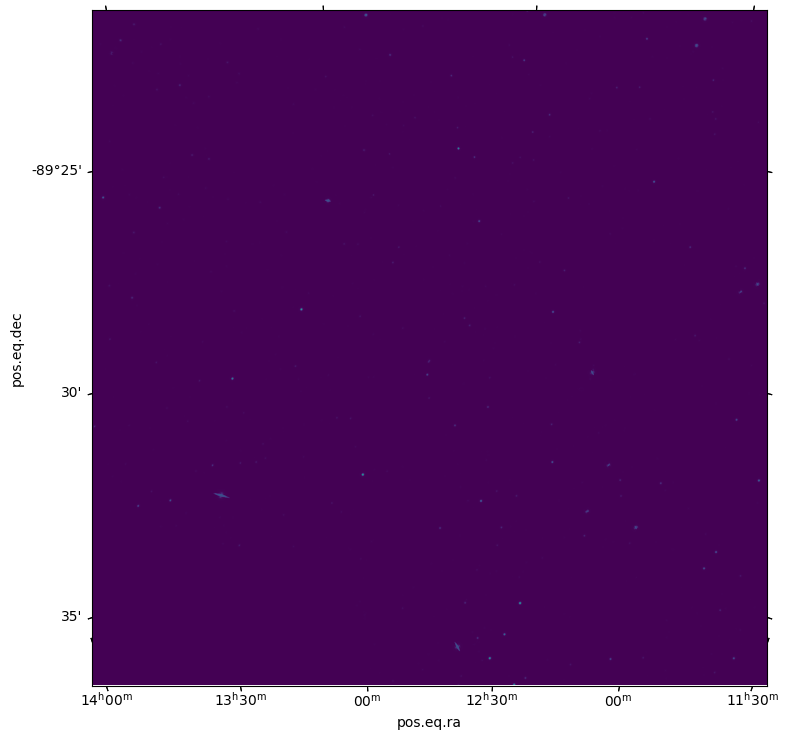

In [61]:
for image in image_array:
    plot_image(image[0], image[1])